In [72]:
import functools
import e3nn_jax as e3nn
import jax
import jax.numpy as jnp
import lovelyplots
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.graph_objects as go
plt.style.use('ipynb')

$Y_{lm}(\theta, \phi) = \sum_{u,v} ({y^{lm}_{uv}})^* \exp{i (u \theta + v \phi)}$


In [73]:
def to_spherical_coords(xyz):
    x, y, z = xyz
    r = jnp.sqrt(x ** 2 + y ** 2 + z ** 2)
    theta = jnp.arccos(z / r)
    phi = jnp.arctan2(y, x)
    return r, theta, phi

def from_lm_index(lm_index):
    l = jnp.floor(jnp.sqrt(lm_index)).astype(jnp.int32)
    m = lm_index - l * (l + 1)
    return l, m

def to_lm_index(l, m):
    return l * (l + 1) + m

def create_Y_signal(l: int, m: int, lmax: int, **s2grid_kwargs) -> e3nn.SphericalSignal:
    coeffs = jnp.zeros((lmax + 1) ** 2).at[to_lm_index(l, m)].set(1)
    coeffs = e3nn.IrrepsArray(e3nn.s2_irreps(lmax), coeffs)
    return e3nn.to_s2grid(coeffs, **s2grid_kwargs)

def create_Fourier_signal(u: int, v: int, **s2grid_kwargs) -> e3nn.SphericalSignal:
    signal = e3nn.SphericalSignal.zeros(**s2grid_kwargs)
    xyz_coords = signal.grid_vectors
    _, theta, phi = jax.vmap(jax.vmap(to_spherical_coords))(xyz_coords)
    values = jnp.exp(1j * (u * theta + v * phi)) / jnp.sqrt(4 * jnp.pi)
    signal = signal.replace_values(
        values
    )
    return signal

def compute_y(lm_index, u, v, lmax, **s2grid_kwargs):
    l, m = from_lm_index(lm_index)
    Y = create_Y_signal(l, m, lmax, **s2grid_kwargs)
    F = create_Fourier_signal(u, v, **s2grid_kwargs)
    product =  (F * Y).integrate().array[0]
    return product

@functools.partial(jax.jit, static_argnames=('lmax', 'res_beta', 'res_alpha', 'quadrature', 'p_val', 'p_arg'))
def compute_y_grid(lmax: int, **s2grid_kwargs):
    lm_indices = jnp.arange((lmax + 1) ** 2)
    us = jnp.arange(-lmax, lmax + 1)
    vs = jnp.arange(-lmax, lmax + 1)
    mesh = jnp.meshgrid(lm_indices, us, vs, indexing='ij')
    compute_y_fn = functools.partial(compute_y, lmax=lmax, **s2grid_kwargs)
    y_grid = jax.jit(jax.vmap(jax.vmap(jax.vmap(compute_y_fn))))(*mesh)
    assert y_grid.shape == ((lmax + 1) ** 2, 2 * lmax + 1, 2 * lmax + 1)
    return y_grid

In [74]:
s2grid_kwargs = dict(
    res_beta=180,
    res_alpha=179,
    quadrature="gausslegendre",
    p_val=1,
    p_arg=-1,
)

lmax = 6
y_grid = compute_y_grid(lmax, **s2grid_kwargs)
y_grid.shape

(49, 13, 13)

In [75]:
l, m = 4, 2
assert jnp.abs(m) <= l

y_lm = y_grid[to_lm_index(l, m)]

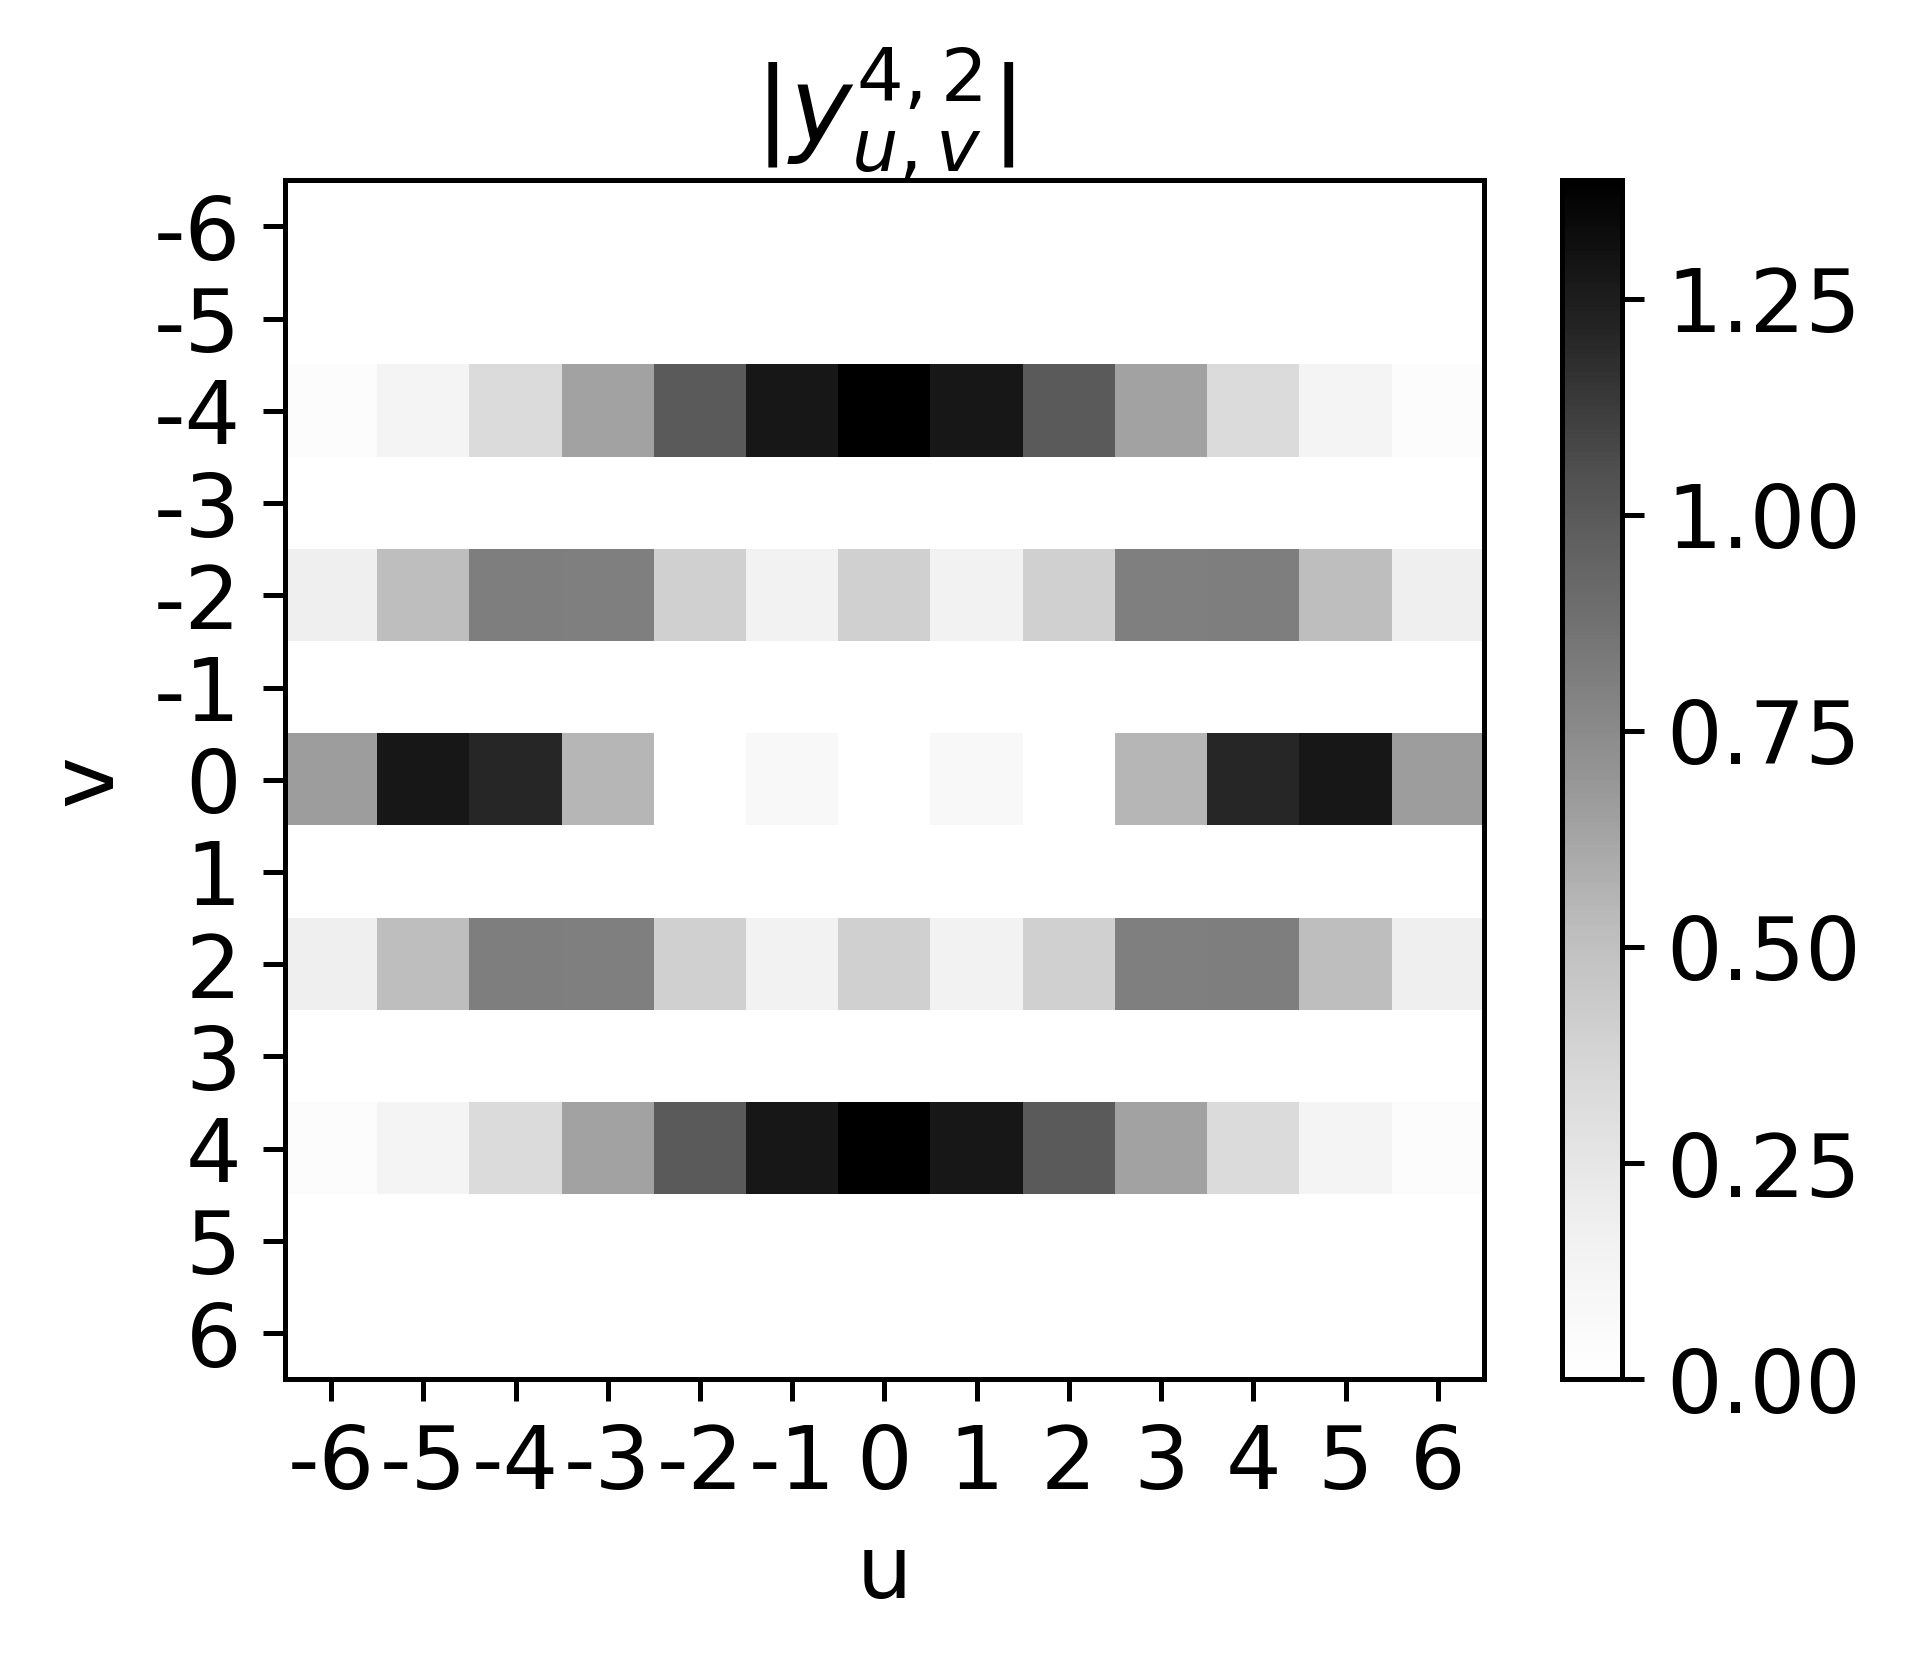

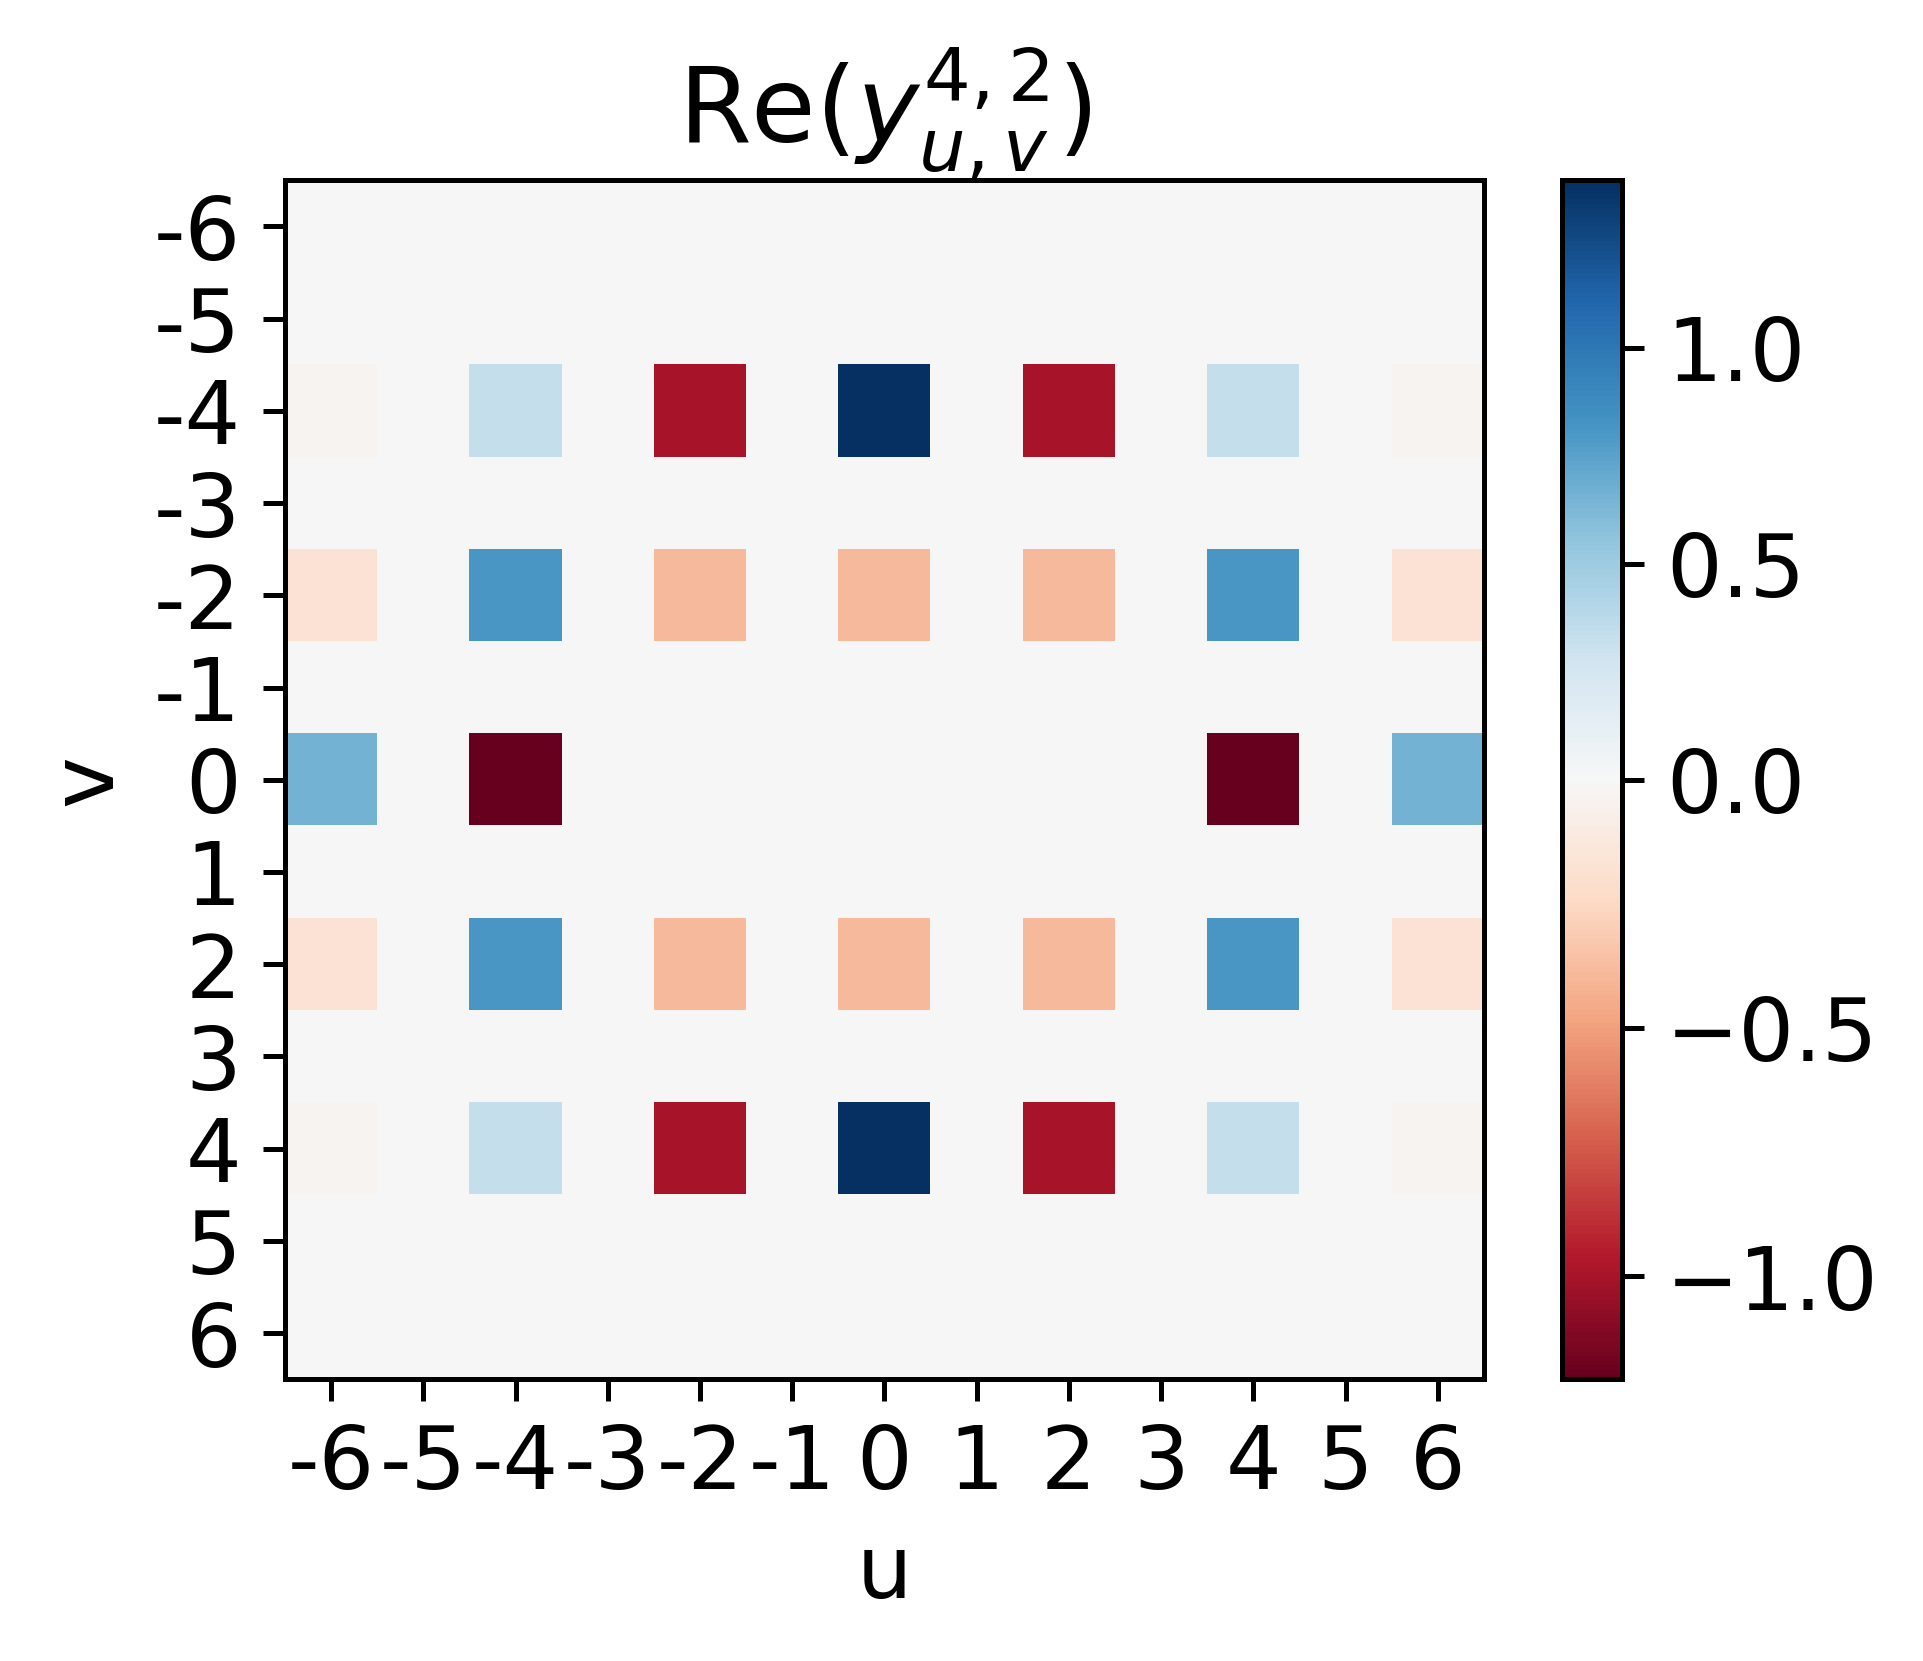

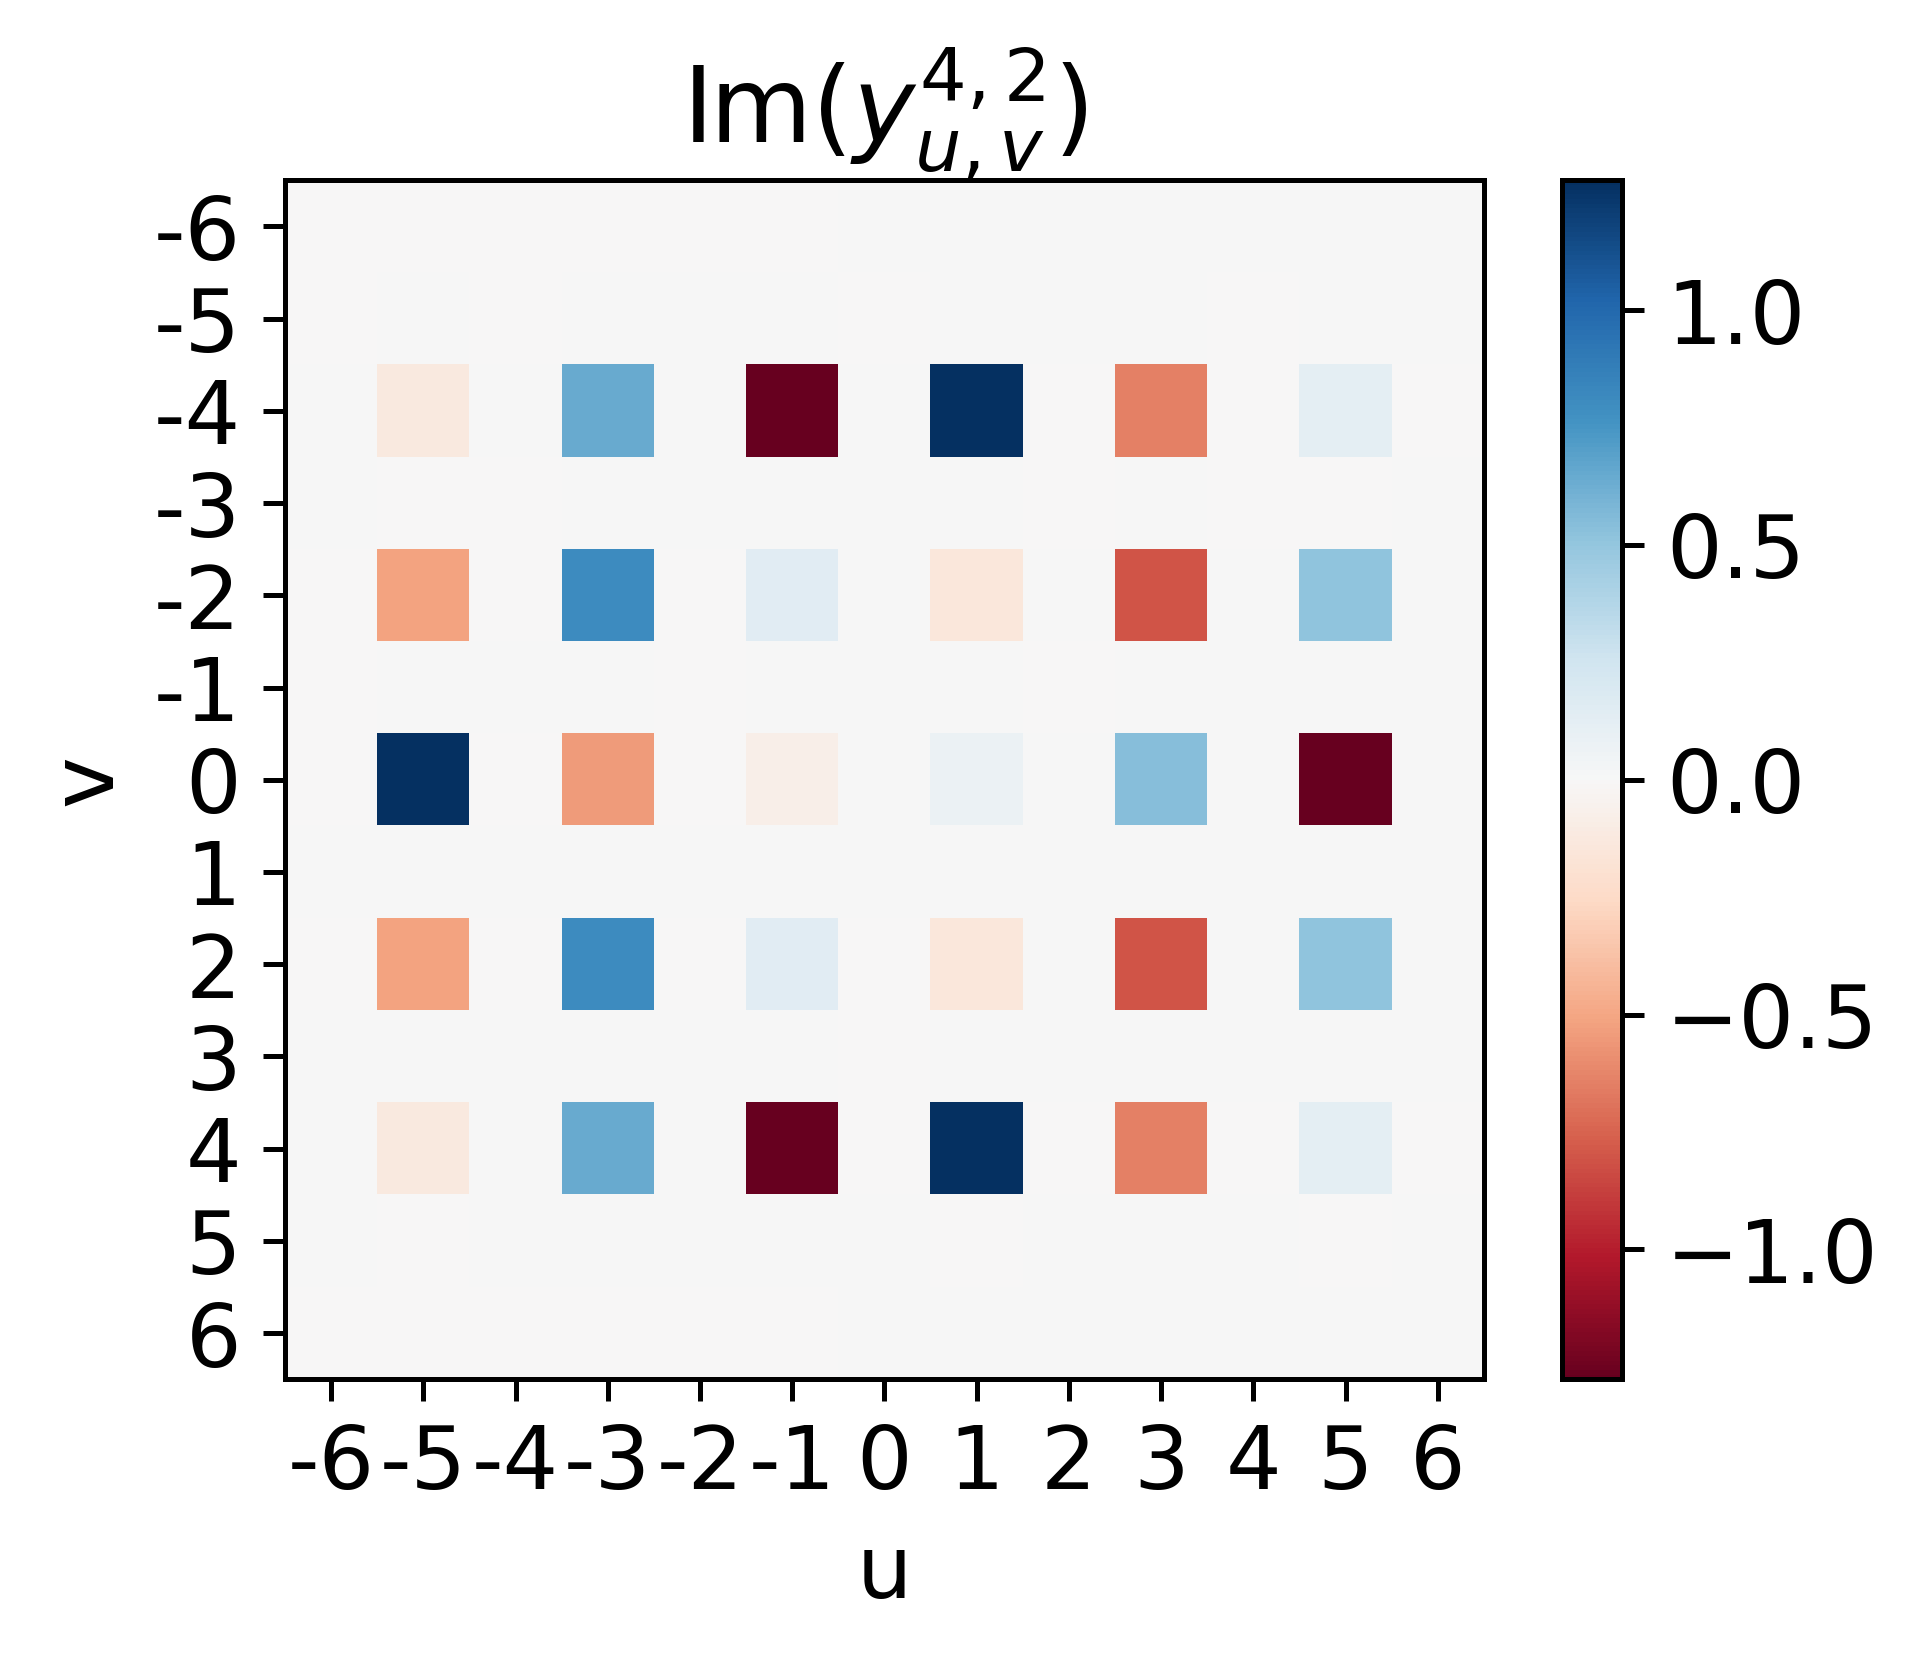

In [76]:
plt.imshow(jnp.abs(y_lm).T, cmap="Grays", vmin=0)
plt.title("$|y_{{u, v}}^{{%d,%d}}|$" % (l, m))
plt.xticks(range(2 * lmax + 1), range(-lmax, lmax + 1))
plt.yticks(range(2 * lmax + 1), range(-lmax, lmax + 1))
plt.xlabel("u")
plt.ylabel("v")
plt.colorbar()
plt.show()

norm = mcolors.TwoSlopeNorm(vmin=jnp.real(y_lm).min(), vcenter=0, vmax=jnp.real(y_lm).max())
plt.imshow(jnp.real(y_lm).T, cmap="RdBu", norm=norm)
plt.title("$\mathrm{{Re}}(y_{{u, v}}^{{%d,%d}})$" % (l, m))
plt.xticks(range(2 * lmax + 1), range(-lmax, lmax + 1))
plt.yticks(range(2 * lmax + 1), range(-lmax, lmax + 1))
plt.xlabel("u")
plt.ylabel("v")
plt.colorbar()
plt.show()


norm = mcolors.TwoSlopeNorm(vmin=jnp.imag(y_lm).min(), vcenter=0, vmax=jnp.imag(y_lm).max())
plt.imshow(jnp.imag(y_lm).T, cmap="RdBu", norm=norm)
plt.title("$\mathrm{{Im}}(y_{{u, v}}^{{%d,%d}})$" % (l, m))
plt.xticks(range(2 * lmax + 1), range(-lmax, lmax + 1))
plt.yticks(range(2 * lmax + 1), range(-lmax, lmax + 1))
plt.xlabel("u")
plt.ylabel("v")
plt.colorbar()
plt.show()

In [84]:
# Transform SH coefficients to 2D Fourier coefficients
x1_lm = e3nn.normal(e3nn.s2_irreps(lmax), key=jax.random.PRNGKey(1)).array
x1_uv = jnp.einsum("a, auv->uv", x1_lm, y_grid)
assert x1_uv.shape == (2 * lmax + 1, 2 * lmax + 1)

x2_lm = e3nn.normal(e3nn.s2_irreps(lmax), key=jax.random.PRNGKey(2)).array
x2_uv = jnp.einsum("a, auv->uv", x2_lm, y_grid)
assert x2_uv.shape == (2 * lmax + 1, 2 * lmax + 1)

In [89]:
# Check that we can convert back to SH coefficients
x1_lm_reconstructed = jnp.einsum("uv, auv->a", x1_uv, jnp.conj(y_grid))
x1_lm_reconstructed[0], x1_lm[0]
# assert jnp.allclose(x1_lm, x1_lm_reconstructed)

(Array(-13.668539-4.7795766e-08j, dtype=complex64),
 Array(-0.76433897, dtype=float32))

In [82]:
# 2D FFT
x1_fft = jnp.fft.fft2(x1_uv)
x2_fft = jnp.fft.fft2(x2_uv)
assert x1_fft.shape == (2 * lmax + 1, 2 * lmax + 1)
assert x2_fft.shape == (2 * lmax + 1, 2 * lmax + 1)

# Product in Fourier space
x1_x2_fft = x1_fft * x2_fft
assert x1_x2_fft.shape == (2 * lmax + 1, 2 * lmax + 1)

# Inverse 2D FFT
x1_x2_uv = jnp.fft.ifft2(x1_x2_fft)
assert x1_x2_uv.shape == (2 * lmax + 1, 2 * lmax + 1)

# Convert back to spherical harmonics
x1_x2_lm = jnp.einsum("uv, auv->a", x1_x2_uv, jnp.conj(y_grid))
assert x1_x2_lm.shape == ((lmax + 1) ** 2,)

# Hmm, the result is not real, but it should be

In [83]:
x1_lm, x2_lm, x1_x2_lm

(Array([-0.76433897,  1.4304022 ,  0.29602233, -0.2620028 ,  0.7534696 ,
         0.38421908,  1.3584293 ,  1.9853761 , -0.5374943 , -1.2144603 ,
         1.1424834 ,  0.23388885, -0.977204  , -0.01199458,  0.6962024 ,
         1.3386534 ,  0.35359615,  1.3369001 ,  1.3061655 , -1.6693078 ,
        -0.12277574,  0.8758087 , -0.38047376, -0.8069952 ,  0.01533398,
         0.10265424,  0.12381285, -1.1133257 , -0.19076478,  1.4280903 ,
        -0.78696334,  1.7904425 ,  0.60417485, -0.29894122,  1.7950747 ,
        -1.4379933 ,  2.10746   , -0.05964555, -1.8987111 , -0.5051671 ,
        -0.56490016, -1.0505275 ,  0.39251304,  0.86643845,  1.1392976 ,
        -0.3791278 ,  1.6222832 ,  0.1660295 , -0.08054032], dtype=float32),
 Array([ 0.5731132 ,  0.94272035,  1.0079833 ,  0.00572866,  1.2520297 ,
        -0.5868313 ,  2.0336902 ,  0.5108802 ,  2.6709468 , -1.0808421 ,
         0.6009734 ,  0.57227564, -0.85571235, -2.0178416 , -0.16342053,
        -0.022926  ,  1.3772305 , -0.7710706 , 

In [79]:
x1_x2_lm

Array([  649.2816  -2638.2659j  , -1692.0989  -1042.4923j  ,
       -1128.8109  -2034.1855j  ,   252.74237  +985.8547j  ,
        1378.4348   +141.26093j ,  -100.262    -854.57684j ,
        1231.3691  -1455.642j   , -1484.5979   +714.6556j  ,
         178.31789 +1115.0009j  ,   599.14215  +716.25183j ,
       -2362.12     +896.99426j ,  -823.8221   -260.51987j ,
          18.541185 +652.30383j ,  1623.9587  +1900.3748j  ,
        1349.4482  +1348.2953j  ,   983.5271   -594.90314j ,
        -863.8504   -565.92535j ,   -70.76925   +15.999687j,
        3385.8547   -307.3858j  ,  -866.354   -1197.1107j  ,
       -1199.2898  +1439.8698j  , -3440.03     +491.71332j ,
       -1799.3458   +492.62643j , -2651.3977    -46.3095j  ,
        -642.2706   -205.94464j ,   624.3132   +105.90709j ,
        1314.4445  -1668.83j    ,  1156.7515   +493.5235j  ,
       -1373.698    -391.31006j ,  2528.4958   -581.9502j  ,
         480.49692  +783.26764j ,  3477.3333   +426.98563j ,
        2826.117    -412

In [80]:
product = e3nn.to_s2grid(e3nn.IrrepsArray(e3nn.s2_irreps(lmax), x1_x2_lm), **s2grid_kwargs)
go.Figure([go.Surface(product.plotly_surface())])


TypeError: z.dtype=complex64 is not supported, see docstring for supported types.